# Potato Disease Classification

Import all the Necessary Libraries

In [46]:
import tensorflow as tf    # TensorFlow is an open source machine learning framework for everyone
from tensorflow.keras import models, layers     # Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow
import matplotlib.pyplot as plt    # Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python

Importing the Data

In [47]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # ImageDataGenerator generates batches of tensor image data with real-time data augmentation

dataset=tf.keras.preprocessing.image_dataset_from_directory(   # Generates a tf.data.Dataset from image files in a directory
    "potato",  # Directory where the datasets are stored
    seed=123,  # Random seed for shuffling and transformations 
    shuffle=True, # Whether to shuffle the data. If set to False, sorts the data in alphanumeric order
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # Size to resize images to after they are read from disk
    batch_size=BATCH_SIZE # Size of the batches of data
)


Found 2152 files belonging to 3 classes.


In [49]:
class_names = dataset.class_names  # Returns the class names present in the dataset
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [50]:
len(dataset) # Returns the number of batches in the dataset

68

In [51]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


DATA VISUALIZATION

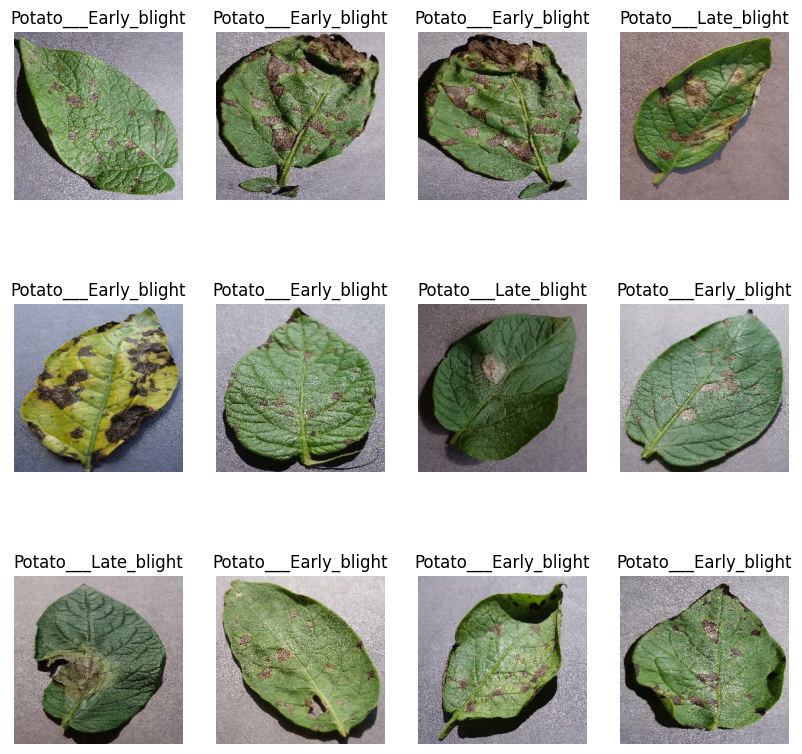

In [52]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [36]:
len(dataset)

68

In [53]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [54]:
import tensorflow as tf

In [56]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1
    
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12, reshuffle_each_iteration=False)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    trainset = ds.take(train_size)
    validset = ds.skip(train_size).take(val_size)
    testset = ds.skip(train_size + val_size)
    
    return trainset, validset, testset


In [57]:
trainset, validset, testset = get_dataset_partitions_tf(dataset)

In [58]:
len(trainset)

54

In [59]:
len(validset)

6

In [60]:
len(testset)

8

# DATA PREPREPROCESSING

# Creating a Layer for Resizing and Normalization


In [68]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [69]:
data_augmentation = tf.keras.Sequential([ # Data augmentation is a technique to artificially create new training data from existing training data
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Randomly flip each image horizontally and vertically
  layers.experimental.preprocessing.RandomRotation(0.2),  # Randomly rotate each image
])

Applying Data Augmentation to Train Dataset

In [70]:
trainset = trainset.map( # Maps map_func across the elements of this dataset
    lambda x, y: (data_augmentation(x, training=True), y)   # Applies the data augmentation to the images   
)

# TRAINING THE MODEL

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [71]:
from tensorflow.keras import layers, models

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3) # Defines the input shape of the model 
# Assuming IMAGE_SIZE, CHANNELS are defined, and resize_and_rescale layer is defined as before
n_classes = 3

model = models.Sequential([ # Sequential groups a linear stack of layers into a tf.keras.Model
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape),   # Convolutional layer that extracts features from a source image    
    layers.MaxPooling2D((2, 2)),     # Max pooling operation for spatial data   
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),   
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # Flattens the input. Does not affect the batch size 
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Softmax activation function   
])

# Assuming you have defined BATCH_SIZE, IMAGE_SIZE, CHANNELS

model.build(input_shape=input_shape)  # This line is optional unless you specifically need to build the model

In [72]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 64)         

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [73]:
model.compile(  # Configures the model for training
    optimizer='adam', # Optimizer that implements the Adam algorithm    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Computes the crossentropy loss between the labels and predictions 
    metrics=['accuracy']    # Used to monitor the training and testing steps    
)   

In [74]:
# Example to inspect the first batch's shape
for images, labels in trainset.take(1):
    print(f'Batch shape: {images.shape}')
    # This should output something like (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


Batch shape: (32, 256, 256, 3)


In [76]:
history = model.fit(
    trainset,
    validation_data=validset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 149s 2s/step - loss: 0.7340 - accuracy: 0.6858 - val_loss: 0.8848 - val_accuracy: 0.6310
Epoch 2/50
54/54 [==============================] - 138s 2s/step - loss: 0.5283 - accuracy: 0.7836 - val_loss: 0.6525 - val_accuracy: 0.6845
Epoch 3/50
54/54 [==============================] - 120s 2s/step - loss: 0.3648 - accuracy: 0.8397 - val_loss: 0.4030 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 131s 2s/step - loss: 0.3012 - accuracy: 0.8773 - val_loss: 0.3703 - val_accuracy: 0.8095
Epoch 5/50
54/54 [==============================] - 121s 2s/step - loss: 0.2905 - accuracy: 0.8773 - val_loss: 0.3181 - val_accuracy: 0.8571
Epoch 6/50
54/54 [==============================] - 112s 2s/step - loss: 0.2448 - accuracy: 0.9028 - val_loss: 0.1526 - val_accuracy: 0.9464
Epoch 7/50
54/54 [==============================] - 133s 2s/step - loss: 0.2100 - accuracy: 0.9213 - val_loss: 0.2076 - val_accuracy: 0.8929
Epoch 8/50
54

In [77]:
model.evaluate(testset)

8/8 [==============================] - 36s 379ms/step - loss: 0.0141 - accuracy: 0.9961


[0.014088277705013752, 0.99609375]

In [78]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

# Plotting the Accuracies

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

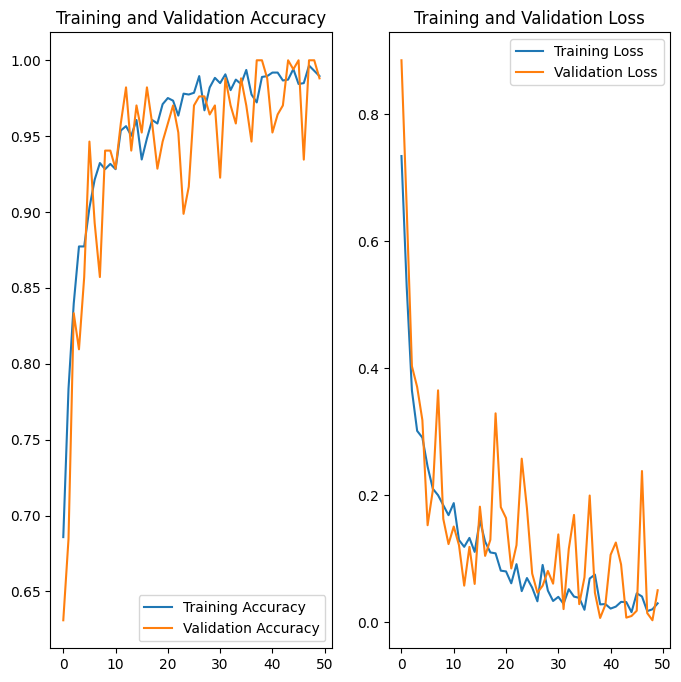

In [81]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 12s 12s/step
predicted label: Potato___Late_blight


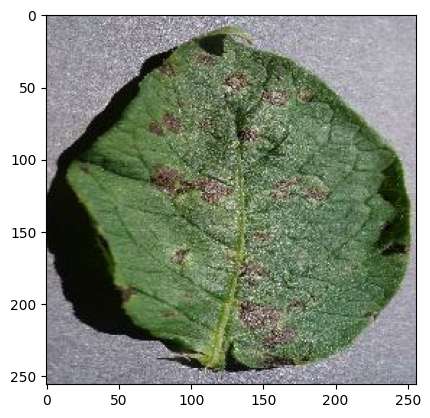

In [83]:
import numpy as np
for images_batch, labels_batch in testset.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


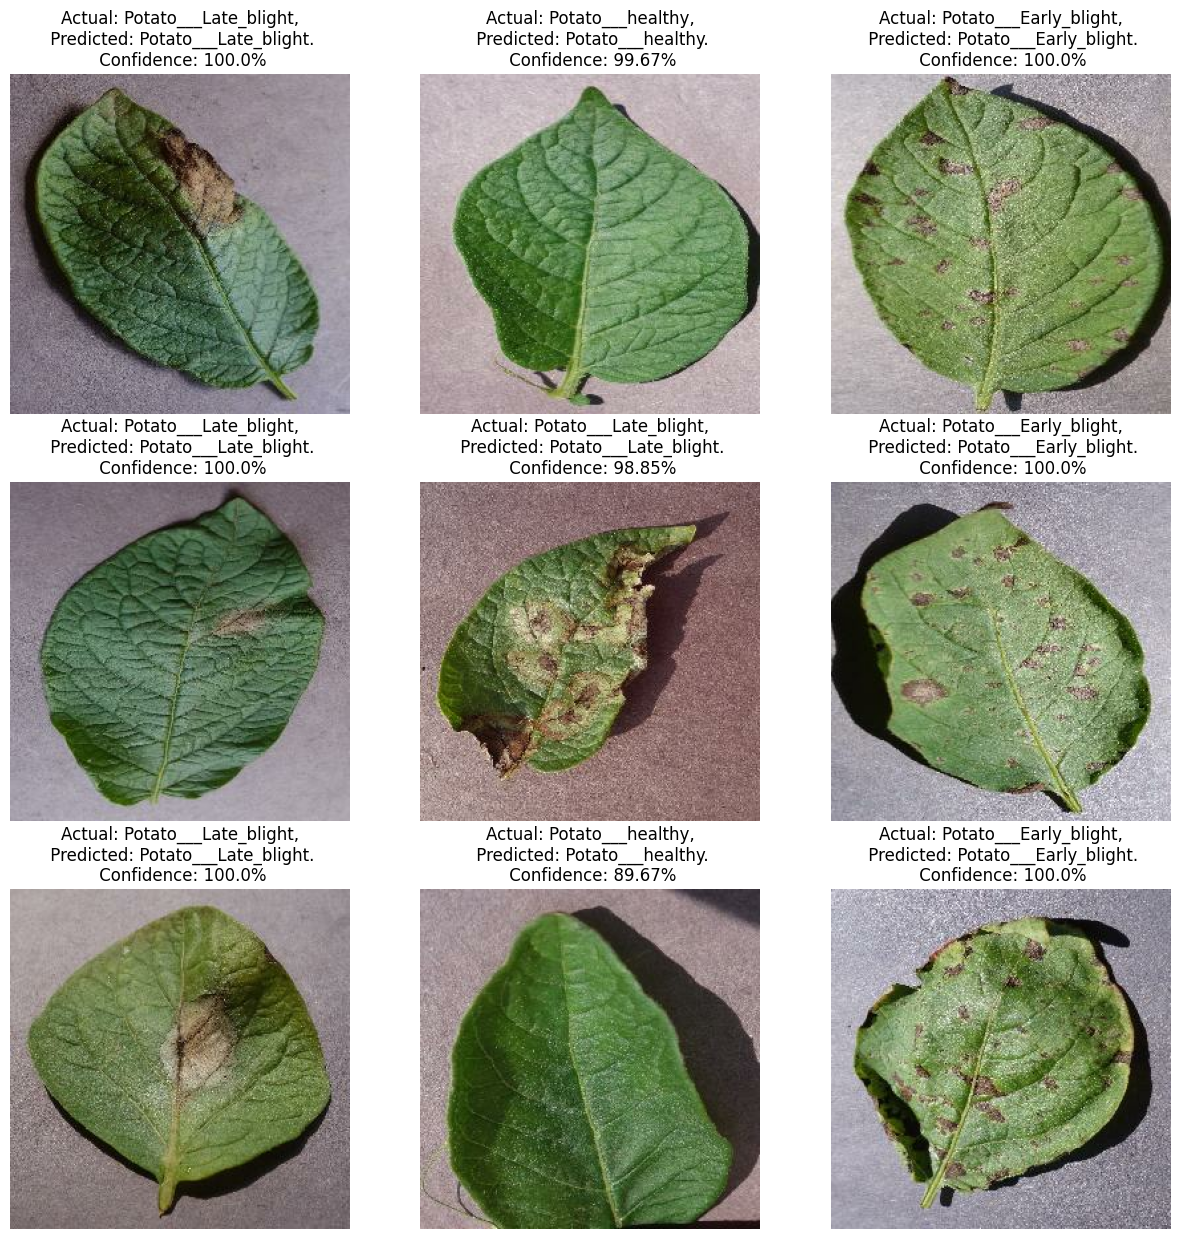

In [85]:
# Now run inference on few sample images

plt.figure(figsize=(15, 15))
for images, labels in testset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model
We append the model to the list of models as a new version

In [89]:
model.save(r"C:\Users\JAFAR\Downloads\PROJECTS\DEEP LEARNING PROJECTS\Potato Disease Classification using CNN\potato_disease_model.h5")

c:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
